In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rba-dataset/LICENSE
/kaggle/input/rba-dataset/README.md
/kaggle/input/rba-dataset/RESULTS.md
/kaggle/input/rba-dataset/rba-dataset.csv
/kaggle/input/rba-dataset/images/rq1-general.png
/kaggle/input/rba-dataset/images/rq1-login-frequency.png
/kaggle/input/rba-dataset/images/rtts-global.png
/kaggle/input/rba-dataset/images/login-overview.png
/kaggle/input/rba-dataset/images/rtts-continents.png
/kaggle/input/rba-dataset/images/rq6-rtt-0_999.png
/kaggle/input/rba-dataset/images/rq2-attack-data.png


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

## 데이터 로드

In [3]:
pd.set_option('display.max_rows', None)  # 모든 행을 출력
pd.set_option('display.max_columns', None)  # 모든 열을 출력

In [4]:
raw = pd.read_csv('/kaggle/input/rba-dataset/rba-dataset.csv')

In [5]:
data = raw.drop(['index', 'User Agent String','Browser Name and Version', 'OS Name and Version', 'Device Type'], axis=1)

In [6]:
# 두 컬럼 중 하나라도 True라면 결과를 True로 설정
data['Is Threat'] = data['Is Account Takeover'] | data['Is Attack IP']

In [7]:
len(data)

31269264

In [8]:
data.head(20)

,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,Login Successful,Is Attack IP,Is Account Takeover,Is Threat
0,2020-02-03 12:43:30.772,-4324475583306591935,NaN,10.0.65.171,NO,-,-,29695,False,False,False,False
1,2020-02-03 12:43:43.549,-4324475583306591935,NaN,194.87.207.6,AU,-,-,60117,False,False,False,False
2,2020-02-03 12:43:55.873,-3284137479262433373,NaN,81.167.144.58,NO,Vestland,Urangsvag,29695,True,False,False,False
3,2020-02-03 12:43:56.180,-4324475583306591935,NaN,170.39.78.152,US,-,-,393398,False,False,False,False
4,2020-02-03 12:43:59.396,-4618854071942621186,NaN,10.0.0.47,US,Virginia,Ashburn,398986,False,True,False,True
5,2020-02-03 12:44:05.160,-4324475583306591935,NaN,209.236.123.126,US,-,-,393398,False,True,False,True
6,2020-02-03 12:44:07.893,7246533443898239661,NaN,80.202.228.214,NO,-,-,15659,True,False,False,False
7,2020-02-03 12:44:12.799,-3243978724802435038,NaN,170.39.78.177,US,-,-,393398,False,False,False,False
8,2020-02-03 12:44:17.474,8076000552587369902,NaN,10.0.61.212,NO,-,-,29695,False,False,False,False
9,2020-02-03 12:44:19.071,-3065936140549856249,NaN,92.221.109.162,NO,Rogaland,Sandnes,29695,True,False,False,False


## ASN 분석

In [9]:
# ASN별 공격 전체 IP 비율과 개수 계산
grouped_data = data.groupby(['ASN'])['Is Threat']
country_attack_rate = grouped_data.mean().reset_index()
country_attack_count = grouped_data.size().reset_index(name='Count')

# 결과를 병합
ASN = pd.merge(country_attack_rate, country_attack_count, on=['ASN'])

# 비율을 숫자로 계산
ASN['Is Threat Rate'] = ASN['Is Threat'] * 100

# 내림차순으로 숫자 기준 정렬
ASN = ASN.sort_values('Is Threat Rate', ascending=False)

print(ASN[:50])

          ASN  Is Threat  Count  Is Threat Rate
7405   502178        1.0      1           100.0
10539  505312        1.0      1           100.0
11281  506054        1.0      2           100.0
2244    42893        1.0     24           100.0
8749   503522        1.0      1           100.0
573     12679        1.0      1           100.0
10564  505337        1.0      1           100.0
574     12683        1.0      1           100.0
11294  506067        1.0      6           100.0
3322    58254        1.0     13           100.0
9317   504090        1.0      2           100.0
10540  505313        1.0      1           100.0
10537  505310        1.0      2           100.0
10512  505285        1.0      1           100.0
12736  507509        1.0      3           100.0
5942   500715        1.0      1           100.0
8737   503510        1.0      1           100.0
11307  506080        1.0      1           100.0
11308  506081        1.0      2           100.0
10525  505298        1.0      1         

In [10]:
ASN['Count'].corr(ASN['Is Threat Rate'])

0.003948363988172055

In [11]:
data[data['ASN']==131].groupby('Country').mean('Is Threat')

,User ID,Round-Trip Time [ms],ASN,Login Successful,Is Attack IP,Is Account Takeover,Is Threat
Country,,,,,,,
DK,-4.324476e+18,NaN,131.0,0.000000,1.00000,0.0,1.00000
ID,-2.687342e+18,NaN,131.0,0.328358,0.19403,0.0,0.19403
JM,-8.704877e+18,NaN,131.0,1.000000,0.00000,0.0,0.00000
KZ,-2.895306e+18,NaN,131.0,0.388889,0.00000,0.0,0.00000
NL,-3.865570e+18,NaN,131.0,0.052632,0.00000,0.0,0.00000
US,-1.834708e+18,NaN,131.0,0.351064,0.00000,0.0,0.00000


In [12]:
data['ASNCountry'] = data['ASN'].astype(str) + ' ' + data['Country']

In [13]:
data.groupby('ASN')['Country'].nunique()

ASN
12         1
131        6
137        3
203        1
224        1
376        1
553        1
559        1
577        1
680        1
702        1
714        1
766        2
803        1
852        2
855        1
1101       1
1136       1
1197       1
1213       2
1237       1
1257       1
1267       1
1299       1
1403       1
1421       2
1547       2
1699       1
1756       1
1764       1
1781       1
1797       1
1835       1
1836       1
1853       1
1901       1
1916       1
1955       1
2042       1
2107       1
2110       1
2115       1
2116       1
2119       1
2200       1
2269       1
2497       1
2501       1
2510       1
2514       1
2516       1
2518       1
2519       1
2527       1
2554       1
2588       1
2590       1
2607       1
2611       1
2614       1
2643       1
2715       1
2716       1
2848       1
2852       1
2856       1
2872       1
2906       1
2907       1
3164       1
3168       1
3170       1
3175       1
3177       1
3178       1
3208       1
3209    

In [14]:
# ASN 별로 IP 주소의 개수를 계산
asn_ip_counts = data.groupby('ASN')['IP Address'].nunique()

# ASN 별로 Threat rate를 계산
asn_threat_rate = data.groupby('ASN')['Is Threat'].mean()

# 결과 데이터프레임 생성
asn_summary = pd.DataFrame({'IP Count': asn_ip_counts, 'Threat Rate': asn_threat_rate})

print(asn_summary)

        IP Count  Threat Rate
ASN                          
12            37     0.000000
131          254     0.141026
137          260     0.011186
203           10     0.000000
224        40760     0.007597
376            2     0.000000
553            8     0.000000
559            9     0.000000
577            1     0.000000
680            8     0.314286
702            1     0.000000
714            1     0.000000
766           89     0.049020
803            1     0.000000
852         1997     0.003253
855            2     0.000000
1101           2     0.000000
1136           2     0.000000
1197          88     0.044068
1213           3     0.000000
1237           4     0.071429
1257           1     0.000000
1267           2     0.000000
1299           1     0.000000
1403           1     0.000000
1421          17     0.000000
1547           6     0.000000
1699         505     0.100221
1756          11     0.000000
1764           2     0.000000
1781           3     0.000000
1797      

In [15]:
asn_summary.sort_values(by = 'IP Count', ascending = False)[:40]

,IP Count,Threat Rate
ASN,,
29695,1017328,0.006991
41164,280262,0.006258
15659,198442,0.005559
11427,161180,0.023861
29492,94991,0.005632
29550,78681,0.035922
25400,77677,0.000000
500194,71375,0.003042
9063,56337,0.025811


In [16]:
temp = asn_summary[asn_summary['IP Count'] != 1017328]

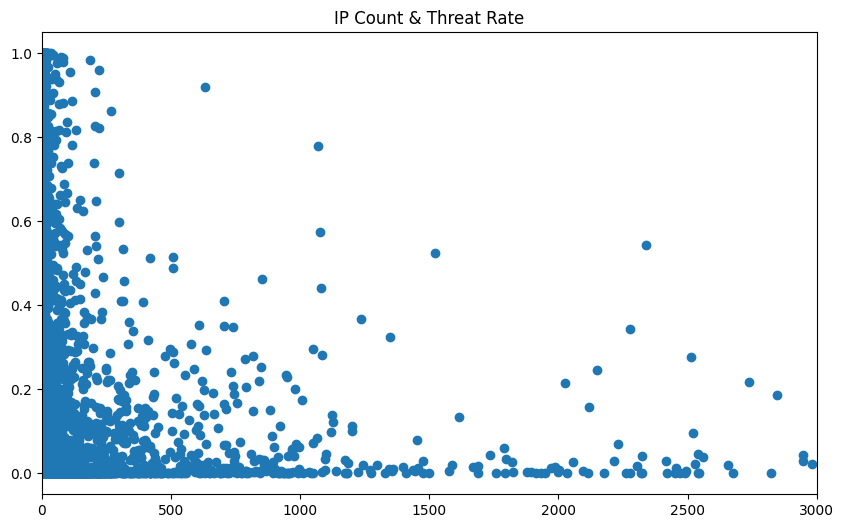

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(data = temp,x = 'IP Count', y = 'Threat Rate')
plt.xlim(0, 3000)
plt.title('IP Count & Threat Rate')
plt.show()

## 나라 별 공격 분석

In [18]:
# 나라별 공격 전체 IP 비율과 개수 계산
grouped_data = data.groupby('Country')['Is Threat']
country_attack_rate = grouped_data.mean().reset_index()
country_attack_count = grouped_data.size().reset_index(name='Count')

# 결과를 병합
result = pd.merge(country_attack_rate, country_attack_count, on='Country')

# 비율을 숫자로 계산
result['Is Threat Rate'] = result['Is Threat'] * 100

# 내림차순으로 숫자 기준 정렬
result = result.sort_values('Is Threat Rate', ascending=False)


print(result)

    Country  Is Threat     Count  Is Threat Rate
55       DM   1.000000         4      100.000000
225      YT   0.666667        12       66.666667
174      RO   0.496482    121535       49.648249
27       BO   0.432182      1939       43.218154
16       BB   0.427586       145       42.758621
197      TG   0.402299        87       40.229885
219      VN   0.361077     20245       36.107681
101      JM   0.347032       438       34.703196
0        AE   0.335054      2325       33.505376
228      ZW   0.298622      1306       29.862175
211      US   0.278247   8685928       27.824672
30       BS   0.270655       351       27.065527
78       GN   0.269327       401       26.932668
42       CL   0.256283     18542       25.628303
144      MW   0.252897      1467       25.289707
12       AW   0.240000        75       24.000000
213      UZ   0.235944      2081       23.594426
172      QA   0.235008       617       23.500810
5        AM   0.231738      2382       23.173804
91       ID   0.2311

In [19]:
result['Count'].corr(result['Is Threat Rate'])

0.024110430463469452

In [20]:
ASN['Count'].corr(ASN['Is Threat Rate'])

0.003948363988172055

In [21]:
len(ASN)

12955

In [22]:
# 나라별 공격 전체 IP 비율과 개수 계산
grouped_data = data.groupby(['Country', 'Region'])['Is Threat']
country_attack_rate = grouped_data.mean().reset_index()
country_attack_count = grouped_data.size().reset_index(name='Count')

# 결과를 병합
result2 = pd.merge(country_attack_rate, country_attack_count, on=['Country', 'Region'])

# 비율을 숫자로 계산
result2['Is Threat Rate'] = result2['Is Threat'] * 100

# 내림차순으로 숫자 기준 정렬
result2 = result2.sort_values('Is Threat Rate', ascending=False)


print(result2[:100])

     Country                         Region  Is Threat  Count  Is Threat Rate
2591      TR                       Osmaniye   1.000000      5      100.000000
872       HK             Yuen Long District   1.000000      2      100.000000
2564      TR                        Giresun   1.000000     20      100.000000
2606      TR                      Zonguldak   1.000000      1      100.000000
2563      TR                      Gaziantep   1.000000     31      100.000000
2607      TR                        Çankırı   1.000000      6      100.000000
2561      TR                       Erzincan   1.000000      3      100.000000
2608      TR                      Şanlıurfa   1.000000     25      100.000000
1322      LR                   Nimba County   1.000000      6      100.000000
2553      TR                         Burdur   1.000000      2      100.000000
864       HK                   Sham Shui Po   1.000000      5      100.000000
1355      LV                         Aglona   1.000000      1   

In [23]:
# 'Is Threat Rate'를 10% 구간으로 나누기
result2['Threat Rate Category'] = pd.cut(result2['Is Threat Rate'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                                      labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])

# 각 범주별로 국가별 등장 횟수 계산
category_country_counts = result2.groupby(['Threat Rate Category', 'Country']).size().reset_index(name='Count')

In [24]:
category_country_counts[category_country_counts['Count'] != 0]

,Threat Rate Category,Country,Count
0,0-10%,AE,1
1,0-10%,AF,2
4,0-10%,AL,1
5,0-10%,AM,1
6,0-10%,AO,1
8,0-10%,AR,5
10,0-10%,AT,6
11,0-10%,AU,3
14,0-10%,AZ,1
15,0-10%,BA,1


In [25]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/tmp/ipykernel_19/3926210268.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [26]:
# 'iso_a3'에서 마지막 문자 제거하여 'iso_a2' 형식으로 변환
world['iso_a2'] = world['iso_a3'].str[:-1]

# 데이터셋의 국가 코드 컬럼 이름이 'Country'라고 가정
merged = world.set_index('iso_a2').join(result.set_index('Country'))


In [27]:
merged.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Is Threat,Count,Is Threat Rate
iso_a2,,,,,,,,,
-9,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN,NaN,NaN
AF,38041754.0,Asia,Afghanistan,AFG,19291,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",0.114797,2291.0,11.479703
AG,31825295.0,Africa,Angola,AGO,88815,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4...",0.000000,241.0,0.000000
AL,2854191.0,Europe,Albania,ALB,15279,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",0.192600,2892.0,19.260028
AR,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",0.031711,133202.0,3.171124


In [28]:
merged.groupby('continent')['Is Threat Rate'].mean().sort_values(ascending=False)

continent
Asia                       9.449299
Africa                     7.927455
South America              7.450593
Europe                     6.208548
North America              5.048658
Oceania                    4.317073
Antarctica                 0.266099
Seven seas (open ocean)    0.266099
Name: Is Threat Rate, dtype: float64

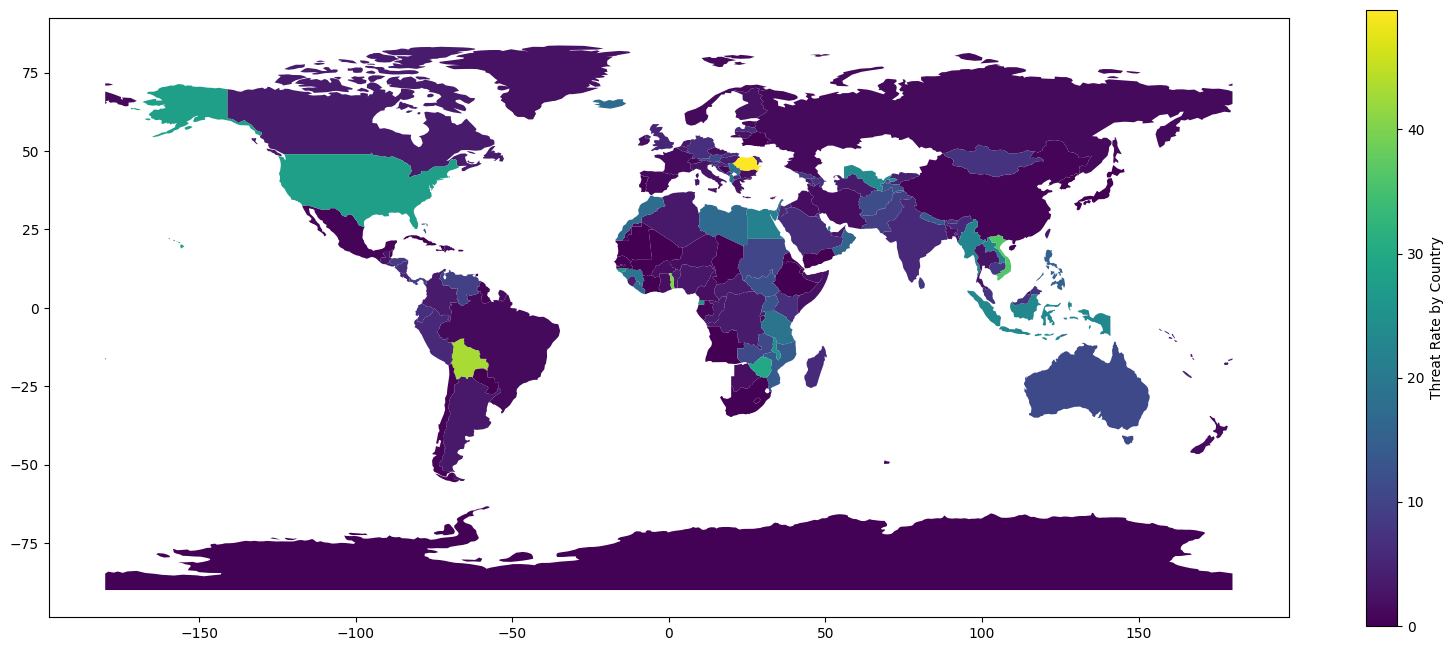

In [29]:
# 지도에 데이터 시각화
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
merged.plot(column='Is Threat Rate', ax=ax, legend=True, legend_kwds={'label': "Threat Rate by Country"})

plt.show()

## RTT 분석

In [30]:
Round_cleaned = data.dropna(subset=['Round-Trip Time [ms]'])

In [31]:
Round_cleaned.groupby('Is Threat')['Round-Trip Time [ms]'].mean()

Is Threat
False    662.178166
True     773.223346
Name: Round-Trip Time [ms], dtype: float64

## 시계열 분석

In [32]:
# IP 주소가 이전 행과 동일한 경우만 필터링
filtered_data = data[data['IP Address'].eq(data['IP Address'].shift()) | data['IP Address'].eq(data['IP Address'].shift(-1))]

filtered_data[:6]

,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,Login Successful,Is Attack IP,Is Account Takeover,Is Threat,ASNCountry
240,2020-02-03 12:47:32.052,-4324475583306591935,NaN,194.152.35.141,RU,Moscow,Moscow,47655,False,True,False,True,47655 RU
241,2020-02-03 12:47:33.165,-4324475583306591935,NaN,194.152.35.141,RU,Moscow,Moscow,47655,False,True,False,True,47655 RU
280,2020-02-03 12:48:00.375,-4324475583306591935,NaN,10.1.38.113,IN,Maharashtra,Mumbai,132996,False,False,False,False,132996 IN
281,2020-02-03 12:48:01.120,-4324475583306591935,NaN,10.1.38.113,IN,Maharashtra,Mumbai,132996,False,False,False,False,132996 IN
815,2020-02-03 12:55:03.044,-4324475583306591935,NaN,103.69.113.0,IN,Maharashtra,Thane,132996,False,False,False,False,132996 IN
816,2020-02-03 12:55:04.004,-4324475583306591935,NaN,103.69.113.0,IN,Maharashtra,Thane,132996,False,False,False,False,132996 IN


In [33]:
indices = data.index[data['IP Address'].eq(data['IP Address'].shift(-1)) & 
                     data['IP Address'].eq(data['IP Address'].shift(-2))]

# 해당 인덱스와 앞뒤로 한 행씩 포함하여 전체 행 추출
rows_to_select = []
for idx in indices:
    rows_to_select.extend([idx, idx+1, idx+2])

# 중복을 제거하고 정렬
rows_to_select = sorted(set(rows_to_select))

# 해당 행들 추출
filtered_data2 = data.loc[rows_to_select]

In [34]:
filtered_data2.head(10)

,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,Login Successful,Is Attack IP,Is Account Takeover,Is Threat,ASNCountry
3584,2020-02-03 13:28:09.625,-4324475583306591935,NaN,158.149.112.14,NO,Innlandet,Folldal,29492,False,False,False,False,29492 NO
3585,2020-02-03 13:28:10.284,-4324475583306591935,NaN,158.149.112.14,NO,Innlandet,Folldal,29492,False,False,False,False,29492 NO
3586,2020-02-03 13:28:11.423,-4324475583306591935,NaN,158.149.112.14,NO,Innlandet,Folldal,29492,False,False,False,False,29492 NO
6536,2020-02-03 14:02:01.833,-4324475583306591935,NaN,79.161.121.255,BR,-,-,29695,False,False,False,False,29695 BR
6537,2020-02-03 14:02:01.870,-4324475583306591935,NaN,79.161.121.255,BR,-,-,29695,False,False,False,False,29695 BR
6538,2020-02-03 14:02:01.915,-4324475583306591935,NaN,79.161.121.255,BR,-,-,29695,False,False,False,False,29695 BR
6539,2020-02-03 14:02:03.412,-4324475583306591935,NaN,79.161.121.255,BR,-,-,29695,False,False,False,False,29695 BR
6672,2020-02-03 14:03:34.260,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6673,2020-02-03 14:03:34.327,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6674,2020-02-03 14:03:34.350,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR


In [35]:
data['Is Threat'].value_counts(normalize=True)

Is Threat
False    0.900956
True     0.099044
Name: proportion, dtype: float64

In [36]:
filtered_data['Is Threat'].value_counts(normalize=True)

Is Threat
False    0.857108
True     0.142892
Name: proportion, dtype: float64

In [37]:
filtered_data2['Is Threat'].value_counts(normalize=True)

Is Threat
False    0.859085
True     0.140915
Name: proportion, dtype: float64

In [38]:
indices = data.index[data['IP Address'].eq(data['IP Address'].shift(-1)) & 
                     data['IP Address'].eq(data['IP Address'].shift(-2)) & 
                     data['IP Address'].eq(data['IP Address'].shift(-3))]

# 해당 인덱스와 앞뒤로 한 행씩 포함하여 전체 행 추출
rows_to_select = []
for idx in indices:
    rows_to_select.extend([idx, idx+1, idx+2, idx+3])

# 중복을 제거하고 정렬
rows_to_select = sorted(set(rows_to_select))

# 해당 행들 추출
filtered_data3 = data.loc[rows_to_select]


In [39]:
filtered_data3.head(20)

,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,Login Successful,Is Attack IP,Is Account Takeover,Is Threat,ASNCountry
6536,2020-02-03 14:02:01.833,-4324475583306591935,NaN,79.161.121.255,BR,-,-,29695,False,False,False,False,29695 BR
6537,2020-02-03 14:02:01.870,-4324475583306591935,NaN,79.161.121.255,BR,-,-,29695,False,False,False,False,29695 BR
6538,2020-02-03 14:02:01.915,-4324475583306591935,NaN,79.161.121.255,BR,-,-,29695,False,False,False,False,29695 BR
6539,2020-02-03 14:02:03.412,-4324475583306591935,NaN,79.161.121.255,BR,-,-,29695,False,False,False,False,29695 BR
6672,2020-02-03 14:03:34.260,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6673,2020-02-03 14:03:34.327,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6674,2020-02-03 14:03:34.350,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6675,2020-02-03 14:03:34.653,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6676,2020-02-03 14:03:34.922,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6677,2020-02-03 14:03:34.954,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR


In [40]:
filtered_data3['Is Threat'].value_counts(normalize=True)

Is Threat
False    0.863378
True     0.136622
Name: proportion, dtype: float64

In [41]:
indices = data.index[data['IP Address'].eq(data['IP Address'].shift(-1)) & 
                     data['IP Address'].eq(data['IP Address'].shift(-2)) & 
                     data['IP Address'].eq(data['IP Address'].shift(-3)) & 
                    data['IP Address'].eq(data['IP Address'].shift(-4))]

# 해당 인덱스와 앞뒤로 한 행씩 포함하여 전체 행 추출
rows_to_select = []
for idx in indices:
    rows_to_select.extend([idx, idx+1, idx+2, idx+3, idx+4])

# 중복을 제거하고 정렬
rows_to_select = sorted(set(rows_to_select))

# 해당 행들 추출
filtered_data4 = data.loc[rows_to_select]


In [42]:
filtered_data4.head(20)

,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,Login Successful,Is Attack IP,Is Account Takeover,Is Threat,ASNCountry
6672,2020-02-03 14:03:34.260,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6673,2020-02-03 14:03:34.327,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6674,2020-02-03 14:03:34.350,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6675,2020-02-03 14:03:34.653,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6676,2020-02-03 14:03:34.922,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
6677,2020-02-03 14:03:34.954,-4324475583306591935,NaN,10.2.77.200,FR,-,-,39421,False,False,False,False,39421 FR
42775,2020-02-03 23:19:02.781,-4324475583306591935,NaN,79.161.248.173,NO,Vestfold og Telemark,Larvik,29695,False,False,False,False,29695 NO
42776,2020-02-03 23:19:07.765,-4324475583306591935,NaN,79.161.248.173,NO,Vestfold og Telemark,Larvik,29695,False,False,False,False,29695 NO
42777,2020-02-03 23:19:09.265,-4324475583306591935,NaN,79.161.248.173,NO,Vestfold og Telemark,Larvik,29695,False,False,False,False,29695 NO
42778,2020-02-03 23:19:09.864,-4324475583306591935,NaN,79.161.248.173,NO,Vestfold og Telemark,Larvik,29695,False,False,False,False,29695 NO


In [43]:
filtered_data4['Is Threat'].value_counts(normalize=True)

Is Threat
False    0.869371
True     0.130629
Name: proportion, dtype: float64

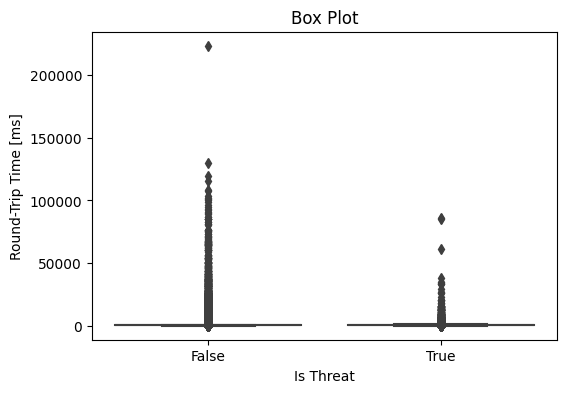

In [44]:
# 박스 플롯 그리기
plt.figure(figsize=(6, 4))
sns.boxplot(x='Is Threat', y='Round-Trip Time [ms]', data=Round_cleaned)
plt.title('Box Plot')
plt.show()